In [1]:
# FOR MASK RCNN / COCO -----------------------------------------
# run this - needed for the Coco Dataset 
# pip install git+https://github.com/philferriere/cocoapi.git#subdirectory=PythonAPI
# repo for it: https://github.com/philferriere/cocoapi
 
# http://cocodataset.org/#download
# from above, download 2017 Train/Val annotations
# 2017 Val images
# put it in a folder named 'data' or edit dataset cell (last one w/code) 

import torch
from torchvision import models, transforms
import torchvision
from torch.utils.data import DataLoader

from pycocotools.coco import COCO

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib, os
import numpy as np

%matplotlib inline

to_pil = transforms.ToPILImage() #to_pil(image.squeeze().cpu()).show()

# Gets the GPU if there is one
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# Mask R-CNN

In [2]:
# not currently used
def show_mask(output, size=(10,10)):
    plt.figure(figsize=size)
    plt.imshow(output['masks'][0].cpu().squeeze())
    plt.axis('off')
    plt.show()

In [3]:
# Network
# https://pytorch.org/docs/stable/torchvision/models.html#object-detection-instance-segmentation-and-person-keypoint-detection
network = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True).to(device)
network.eval();

In [4]:
# Coco Dataset
coco_val = torchvision.datasets.CocoDetection("data/val2017", annFile="data/annotations/instances_val2017.json",
                                             transform=transforms.ToTensor())

labels = ['__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair dryer', 'toothbrush'
] # list of labels in CocoDetection
len(labels)

loading annotations into memory...
Done (t=0.49s)
creating index...
index created!


91

In [5]:
# https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html
# haven't really looked at that much yet. might help a lot

# image sizes
for i in range(5):
    print(coco_val[i][0].shape)
#coco_val[2][0] # 2nd instance -- 0 = image (1 = segmentation)

torch.Size([3, 426, 640])
torch.Size([3, 640, 586])
torch.Size([3, 483, 640])
torch.Size([3, 500, 375])
torch.Size([3, 640, 428])


In [6]:
j = 2 # which image
image = coco_val[j][0].unsqueeze(0).to(device)
with torch.no_grad(): # to help keep CUDA memory free (hopefully)
    output = network(image)[0]
print(output.keys())
print("number of boxes/labels", len(output['labels']))

dict_keys(['boxes', 'labels', 'scores', 'masks'])
number of boxes/labels 100


# of Boxes: 100
Box #0 :  potted plant 99.3111% ,  11489
Box #1 :  chair 99.2220% ,  8937
Box #2 :  potted plant 99.0217% ,  5543
Box #3 :  bed 98.8446% ,  78769
Box #4 :  bottle 96.6380% ,  642
Box #5 :  book 85.5224% ,  794
Box #6 :  book 81.7318% ,  3399
Box #7 :  book 80.1824% ,  6500


{'bed', 'book', 'bottle', 'chair', 'potted plant'}

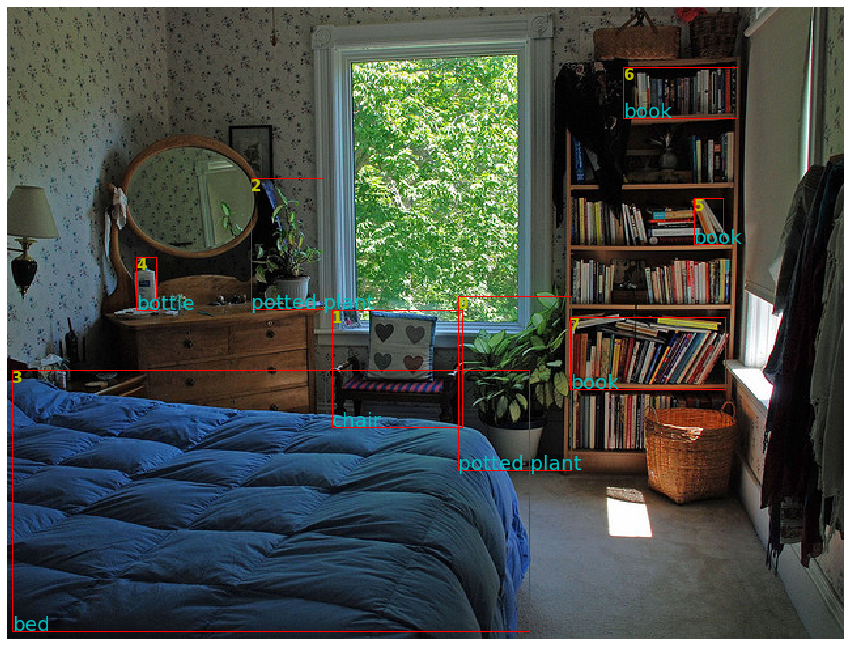

In [7]:
score_threshold = 0.75

# plot image with boxes
to_plot_image = image.cpu().squeeze().numpy().transpose(1, 2, 0)
scores = output['scores'].cpu()
length = len(scores)

fig = plt.figure(figsize=(15,15))
plt.imshow(to_plot_image)
plt.axis('off')
print('# of Boxes:', len(output['boxes']))

# go through each box
i = 0
while i < length and scores[i] > score_threshold:
    box = [output['boxes'][i][j].cpu().item() for j in range(4)] # or output['boxes'][i].cpu()
    width = box[2] - box[0] # of box
    height = box[3] - box[1] # of box
    label = labels[output['labels'][i].item()]
    #if height < 10 or width < 10 or area < 50: continue 
    
    # add a rectangle ((x,y), w, h)
    fig.get_axes()[0].add_patch(matplotlib.patches.Rectangle((box[0], box[1]), 
                                                             width, height, fill=False, 
                                                             color='r', linewidth=1))
    plt.annotate(i, xy=(box[0], box[1]+10), color='y', fontsize=15, fontweight='semibold') # box #
    plt.annotate(label, xy=(box[0], box[1]+height), color='c', fontsize=20) # box label
    
    print('Box #'+ str(i), ": ", label,  
              "{:.4f}".format(scores[i].item()*100)+"%", ", ", int(width*height)) # print info of box
    i += 1
# end - while

plt.savefig(os.path.join('pics', 'hi.png')) # make sure you have a pics folder

set([labels[output['labels'][j]] for j in range(i-1)]) # all different labels

In [8]:
# puts a mask in a dataframe
mask = output['masks'][0].cpu().squeeze()
df = pd.DataFrame(mask.numpy())